Ce cahier compare les performances de transfer learning avec et sans transfer learning pour la classification des signaux bruyants.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from d2l import torch as d2l
import time
from sklearn.metrics import f1_score
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
path = "F:/Document/France/ENPC/Cours/S5/Projet/data/"
os.chdir(path)
df_data = pd.read_csv("alldata.csv", header=0)

In [3]:
df_data = df_data.dropna()

list_vitesse = []
for i in df_data['Vitesse']:
    list_vitesse.append(eval(i))

list_frf_reel = []
for i in df_data['FRF réel']:
    list_frf_reel.append(eval(i))

list_frf_imag = []
for i in df_data['FRF imag']:
    list_frf_imag.append(eval(i))

np_vitesse = np.array(list_vitesse)
np_frf_reel = np.array(list_frf_reel)
np_frf_imag = np.array(list_frf_imag)
np_frf = np.sqrt(np.square(np_frf_reel) + np.square(np_frf_imag))

In [4]:
binary_labels = np.load("binary_labels.npy")

In [5]:
np.unique(binary_labels, return_counts=True)

(array([False,  True]), array([20497,  2023], dtype=int64))

In [6]:
np_labels = pd.get_dummies(binary_labels).values

In [7]:
ts_vitesse = torch.tensor(np_vitesse, dtype=torch.float32).reshape(np_vitesse.shape[0], 1, np_vitesse.shape[1])
ts_frf = torch.tensor(np_frf, dtype=torch.float32).reshape(np_frf.shape[0], 1, np_frf.shape[1])
ts_label = torch.tensor(np_labels, dtype=torch.float32)
ts_feature = torch.concat((ts_vitesse, ts_frf), dim=1)

In [8]:
threshold1 = int(0.6*ts_feature.shape[0])
threshold2 = int(0.8*ts_feature.shape[0])
X_train = ts_feature[:threshold1]
Y_train = ts_label[:threshold1]
X_valid = ts_feature[threshold1:threshold2]
Y_valid = ts_label[threshold1:threshold2]
X_test = ts_feature[threshold2:]
Y_test = ts_label[threshold2:]

In [39]:
class Residual1d(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv1d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))  # conv1 +batchnorm + relu
        Y = self.bn2(self.conv2(Y))  # conv2 + batchnorm
        if self.conv3:
            X = self.conv3(X)
        Y += X   # residual + base
        return F.relu(Y)

def resnet_block1d(input_channels, num_channels, num_residuals,
                   first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual1d(input_channels, num_channels,
                                  use_1x1conv=True, strides=2))
        else:
            blk.append(Residual1d(num_channels, num_channels))
    return blk

# stage1, length / 2
b1 = nn.Sequential(nn.Conv1d(2, 16, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm1d(16), nn.ReLU(),
                    nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
# stage2, keep form
b2 = nn.Sequential(*resnet_block1d(16, 16, 2, first_block=True))
# stage3, channel * 2
b3 = nn.Sequential(*resnet_block1d(16, 32, 2))
# stage4, channel * 2, length / 2
b4 = nn.Sequential(*resnet_block1d(32, 64, 2))
b5 = nn.Sequential(*resnet_block1d(64, 128, 2))
clone = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(128, 5))

In [40]:
# stage1, length / 2
b11 = nn.Sequential(nn.Conv1d(2, 16, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm1d(16), nn.ReLU(),
                    nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
# stage2, keep form
b12 = nn.Sequential(*resnet_block1d(16, 16, 2, first_block=True))
# stage3, channel * 2
b13 = nn.Sequential(*resnet_block1d(16, 32, 2))
# stage4, channel * 2, length / 2
b14 = nn.Sequential(*resnet_block1d(32, 64, 2))
b15 = nn.Sequential(*resnet_block1d(64, 128, 2))
resnet = nn.Sequential(b11, b12, b13, b14, b15,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(128, 2))

In [41]:
clone.load_state_dict(torch.load('resnet.params'))

<All keys matched successfully>

In [42]:
clone[7] = nn.Linear(clone[7].in_features, 2)

In [43]:
nn.init.xavier_uniform_(clone[7].weight)

Parameter containing:
tensor([[ 0.0415,  0.1758, -0.0440, -0.0385,  0.1695,  0.0738,  0.0999, -0.1602,
          0.1296, -0.1894,  0.1013,  0.1384,  0.0268, -0.1811,  0.0578, -0.0782,
         -0.1938, -0.0190,  0.1883,  0.1986,  0.0517,  0.1871,  0.0552,  0.0115,
         -0.0421,  0.0860, -0.1841,  0.1151,  0.0665,  0.1925,  0.1373,  0.1507,
         -0.1848,  0.1204, -0.1013, -0.0701,  0.1669, -0.0820,  0.1271,  0.0228,
         -0.1893, -0.2031,  0.0872, -0.0445,  0.1312, -0.1354,  0.0023, -0.1387,
          0.1577, -0.1019,  0.0615,  0.0095,  0.0242,  0.1151,  0.0049, -0.0204,
          0.1610,  0.0485,  0.1112,  0.0045, -0.1228, -0.0685, -0.0441, -0.1939,
         -0.2013, -0.0956,  0.1682, -0.0108, -0.0960,  0.1287, -0.0913,  0.0440,
         -0.1747, -0.0270, -0.1880, -0.1233, -0.2057, -0.0666,  0.0512, -0.2131,
          0.0193, -0.1907,  0.1457, -0.0443,  0.1254,  0.1706, -0.0919,  0.0687,
          0.0691,  0.0102,  0.2116,  0.2092, -0.1750,  0.1571, -0.1854, -0.1341,
      

In [32]:
def try_gpu(i=0):
    """if gpu exist, return gpu(i), otherwise, return cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    y = y.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    if not device: 
        device = try_gpu()
    metric = d2l.Accumulator(2) 
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y), y.shape[0])
    return metric[0] / metric[1]

def train_accuracy(net, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    train_iter = d2l.load_array((X_train, Y_train), batch_size)
    test_iter = d2l.load_array((X_valid, Y_valid), batch_size,
                               is_train=False)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

def train_fine_tuning(net, Xtrain, Ytrain, Xvalid, Yvalid, num_epochs, lr, weight_decay, batch_size, device):
    print('training on', device)
    net.to(device)
    train_iter = d2l.load_array((Xtrain, Ytrain), batch_size)
    test_iter = d2l.load_array((X_valid, Y_valid), batch_size,
                               is_train=False)
    params_1x = [param for name, param in net.named_parameters()
        if name not in ["7.weight", "7.bias"]]
    optimizer = torch.optim.Adam([{'params': params_1x},
                                {'params': net[7].parameters(),
                                'lr': lr * 10}],
                                lr=lr, 
                                weight_decay=weight_decay)
    
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [44]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
num_epochs, lr, weight_decay, batch_size, device = 5, 1e-3, 0, 64, try_gpu()

loss 0.049, train acc 0.981, test acc 0.989
1988.9 examples/sec on cuda:0


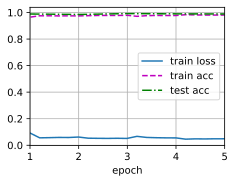

In [45]:
train_fine_tuning(clone, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

In [46]:
def plot_confusion_matrix(cm):
    df_cm = pd.DataFrame(cm / np.sum(cm, axis=1).reshape(-1, 1), range(2), range(2))
    plt.figure(figsize = (6,6))
    sn.heatmap(df_cm, annot=True)
    plt.show()

def evaluate_net(net, X_test, Y_test):
    net.cpu()
    Y_pred = net(X_test)
    np_Y_pred = Y_pred.argmax(axis=1).numpy()
    np_Y_test = Y_test.argmax(axis=1).numpy()
    f1s = f1_score(np_Y_test, np_Y_pred, average='weighted')
    print(f'F1 score: {f1s:.3f}')
    cm = confusion_matrix(np_Y_test, np_Y_pred)
    plot_confusion_matrix(cm)

F1 score: 0.947


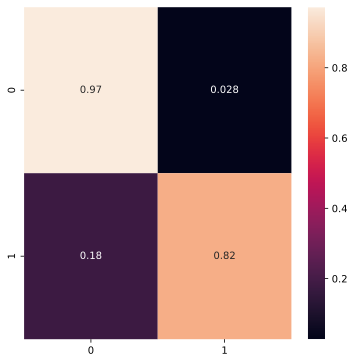

In [47]:
evaluate_net(clone, X_test, Y_test)

loss 0.060, train acc 0.974, test acc 0.986
1808.8 examples/sec on cuda:0


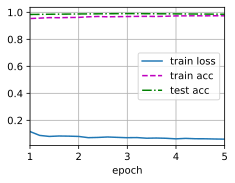

In [48]:
train_accuracy(resnet, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

F1 score: 0.959


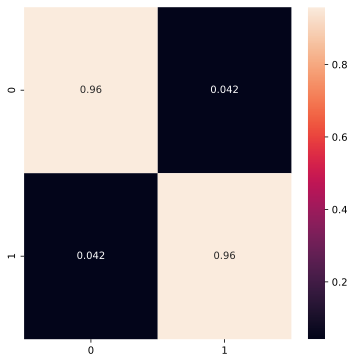

In [49]:
evaluate_net(resnet, X_test, Y_test)